# Chapter 10. Attention Mechanisms

- 시신경망의 연구에서 착안
  - 시신경은 인간의 두뇌가 처리할 수 있는것을 뛰어넘는 정보를 받아들임
  - 의식적인 집중을 통해 방대한 시각 정보 중 의미있는 부분에 대한 선택적인 처리를 함
  - 인지 신경과학 분야에서 19세기부터 연구
  - Nadaraya-Watson kernel regression 연구에서 ML에 이러한 Attention mechanism을 도입

- 주요 내용
  - Attention functions에 대한 소개 (특히 Bahdanau attention의 디자인에 어떻게 사용되는지와 관련)
    - Bahdanau attention은 bidirectionally alignable하고 미분 가능한 매우 혁신적인 attention model임.
  - 후반부에 multi head attention과 self-attention 디자인에 대한 내용을 다루면서 transformer architecture에 대해
  
## Attention Cues

> 환경의 정보는 희소하지 않다. 희소한 가치를 갖는 것은 Attention 이다.

### Attention Cues in Biology

- attention을 설명하는 2-components framework이 유행 
- nonvolitional cue vs volitional cue
  - Nonvolitional Cue
    - 주변 환경에서 특징적이거나 잘 드러나 보이는 것에 기반
    - 비자발적 & 무식적 attention 
    - 예: 흑백 사진 중에 컬러 물체. 
  - Volitional Cue
    - 의식적 노력을 통해 주의를 기울이는 것
    - 예 : 커피를 마시고 읽을 책을 찾는 것. 

### Queries, Keys and Values

- 위 2가지 요소를 통해 attention mechanism을 설계하려면...
  - 최초에 nonvolitional cue만 존재한다고 가정, saliency를 찾기 위한 것은 fully-connected layer 혹은 max or avg pooling layer 만으로도 할 수 있다.
  - 하지만 이들과 구별되는 것은 volitional cue을 위한 구조임.
    - attention mechanism에서는 volitional cue를 query라 칭하고..
    - 주어진 query에 따라 sensory inputs에 대한 선택 편향을 갖게됨.
- ```Queries``` = Volitional Cue
- ```Values``` = Sensory Inputs
- ```Keys``` = Nonvolitional Cue
- Every ```value``` is paired with a ```key```
- Some function of query and key ```f(query, key)``` => bias selection over values
- Attention mechanis의 설계에는 다양한 alternatives가 있음 

### Attention Pooling

- 주어진 Query에서 Keys의 정보를 이용하여 Values에 대한 Selection Bias를 만들어 내는 것
-
### Visualize of Attention
- average pooling은 uniform한 weight로 input에 대해 weighted average를 구하는 것으로 볼 수 있다.
- attention pooling은 다 똑같은데 weight가 uniform한 것이 아니라 key와 query에 의해 계산된다는 것만 다르다.



In [3]:
import torch 
from d2l import torch as d2l

#@save 
def show_heatmaps(matrices, xlabel, ylabel, titles=None, 
                  figsize=(2.5, 2.5), cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, 
                                 sharex=True, sharey=True, squeeze=False)
    
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    

- 아래 단순화 된 예시는 query와 key가 같은 값은 갖는 경우 1의 weight를 갖는 attention weight의 예시임.

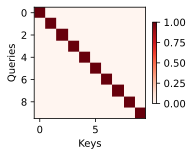

In [4]:
attention_weights = torch.eye(10).reshape((1,1,10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## Attention Pooling ```Nadaraya-Watson Kernel Regression```

- Attention pooling은 결국 Query와 Key의 상호작용의 결과이다. 
- Attention pooling은 선택적으로 입력을 취합하여 출력을 생성한다. 


In [5]:
import torch
from torch import nn
from d2l import torch as d2l



### Generating the Dataset

- 예시를 위해 y_i = 2 * sin(x_i) + x_i ** 0.8 + e의 관계를 갖는 y와 x pair의 데이터셋을 생성


In [7]:
import torch

n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)
x_train

tensor([0.0502, 0.0948, 0.1303, 0.1637, 0.1924, 0.2045, 0.3193, 0.4179, 0.4613,
        0.5308, 0.6500, 0.8353, 1.0351, 1.1491, 1.1852, 1.2170, 1.3390, 1.6289,
        2.1570, 2.1680, 2.2934, 2.3313, 2.3484, 2.4212, 2.5667, 2.8122, 2.8244,
        2.8812, 2.9317, 3.0351, 3.1061, 3.1726, 3.2545, 3.3017, 3.3273, 3.4047,
        3.4981, 3.7147, 3.9493, 3.9646, 3.9894, 4.0565, 4.1130, 4.1294, 4.1916,
        4.1933, 4.3301, 4.5108, 4.5640, 4.7888])

In [26]:
def f(X: torch.Tensor):
    return 2 * torch.sin(X) + X**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, size=(n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

### Average Pooling

- "dumbest estimator"
- 단순히 y_train의 모든 값에 대한 평균
- x_i에 대한 의존성 없음 (일직선)

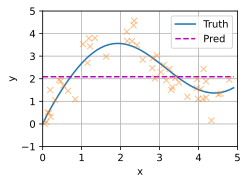

In [25]:
from d2l import torch as d2l
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], 
             xlim=[0,5], ylim=[-1,5])
    d2l.plt.plot(x_train, y_train, 'x', alpha=0.5)

y_hat =  torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### Nonparametric Attention Pooling

- Naradaya-Watson에 의해 제안된 방식은 Value (y_i)의 weight term에 Key(x_i)와 Query(x)의 kernel 함수에 의해 표현되는 Naradaya-Watson kernel regression이다. 
- 모든 key-value pair에 대해 유효한 (음수가 아니며 합치면 1이 되는..) 성질의 확률 분포를 갖는 weight를 얻을 수 있음.
- Nadaraya-Watson attention pooling은 non-parameteric attention pooling의 대표적인 케이스


In [29]:

X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
X_repeat

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]])